# Asignment for ML Systems & Control

## 1. Modeling the System Dynamics

### 1.1 Gaussian Process (GP) model

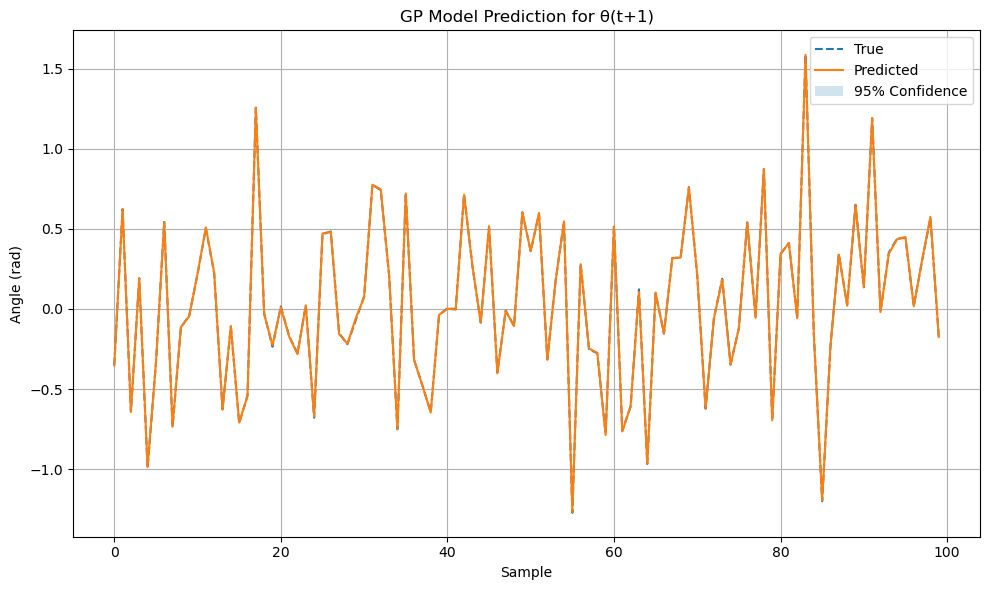

Trained GP kernel: RBF(length_scale=2.46) + WhiteKernel(noise_level=6.42e-05)
Test MSE: 2.0827832190739692e-05


In [7]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# === Load dataset (no header) ===
DATA_PATH = "gym-unbalanced-disk-master/disc-benchmark-files/training-val-test-data.csv"
df = pd.read_csv(DATA_PATH, comment="#", header=None, names=["u", "th"])

# === Drop missing data ===
df.dropna(inplace=True)

# === Build NARX features ===
df['th_t'] = df['th']
df['th_tm1'] = df['th'].shift(1)
df['u_t'] = df['u']
df['u_tm1'] = df['u'].shift(1)
df['th_tp1'] = df['th'].shift(-1)  # target

df.dropna(inplace=True)

# === Inputs (X) and target (y) ===
X = df[['th_t', 'th_tm1', 'u_t', 'u_tm1']]
y = df['th_tp1']

# === Split dataset ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Instead of fitting the full dataset, sample a manageable subset
X_sample = X_train.sample(n=2000, random_state=21)
y_sample = y_train.loc[X_sample.index]

# === GP kernel: RBF + noise ===
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)

# === Fit GP model ===
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(X_sample, y_sample)

# === Predict ===
y_pred, y_std = gp.predict(X_test, return_std=True)

# === Plot results ===
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:100], label="True", linestyle='dashed')
plt.plot(y_pred[:100], label="Predicted")
plt.fill_between(range(100),
                 y_pred[:100] - 2*y_std[:100],
                 y_pred[:100] + 2*y_std[:100],
                 alpha=0.2, label="95% Confidence")
plt.title("GP Model Prediction for θ(t+1)")
plt.xlabel("Sample")
plt.ylabel("Angle (rad)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print kernel info ===
print("Trained GP kernel:", gp.kernel_)

# === Evaluate model performance ===
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)